<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/LastYear/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import joblib
import os

def _check_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

data_folder = _check_folder('./data/')
results_folder = _check_folder('./results/')
memory = joblib.Memory(location='./Temp/')

def download_steinmetz_data():
    import requests
    fname = []
    for j in range(3):
      fname.append(data_folder+'steinmetz_part%d.npz'%(j+1))
    url = ["https://osf.io/agvxh/download"]
    url.append("https://osf.io/uv3mw/download")
    url.append("https://osf.io/ehmw2/download")
    
    for j in range(len(url)):
      if not os.path.isfile(fname[j]):
        try:
          r = requests.get(url[j])
        except requests.ConnectionError:
          print("!!! Failed to download data !!!")
        else:
          if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
          else:
            with open(fname[j], "wb") as fid:
              fid.write(r.content)
              
download_steinmetz_data()

@memory.cache
def prepare_data(session=11):
    alldat = np.array([])
    for j in range(3):
      alldat = np.hstack((alldat, np.load(data_folder+'steinmetz_part%d.npz'%(j+1), allow_pickle=True)['dat']))
    dat = alldat[session]
    n_timebins = dat['spks'].shape[2]
    labels = dat['response']+1 # right - nogo - left (-1, 0, 1)
    regions = np.unique(dat['brain_area'])
    spikes_per_region = dict()
    for region in regions:
        spikes_per_region[region] = dat['spks'][np.where(dat['brain_area']==region)]
    return spikes_per_region, labels, n_timebins

    
@memory.cache
def prepare_data_pupil(session=11):
    alldat = np.array([])
    for j in range(3):
      alldat = np.hstack((alldat, np.load(data_folder+'steinmetz_part%d.npz'%(j+1), allow_pickle=True)['dat']))
    dat = alldat[session]
    n_timebins = dat['spks'].shape[2]
    labels = dat['pupil'][0]
    regions = np.unique(dat['brain_area'])
    spikes_per_region = dict()
    for region in regions:
        spikes_per_region[region] = dat['spks'][np.where(dat['brain_area']==region)]
    return spikes_per_region, labels, n_timebins

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

@memory.cache
def simple_decoder(session=11):
    model = LogisticRegression(penalty='l2',multi_class='ovr',solver='liblinear')
    spikes_per_region, y, n_timebins = prepare_data(session=session)
    regions = spikes_per_region.keys()
    scores = np.zeros((len(regions),n_timebins))
    for region,(_, spikes) in enumerate(spikes_per_region.items()):
        for t in range(n_timebins):
            X = spikes[:,:,t].T
            score = cross_val_score(model, X, y, cv=5)
            scores[region,t] = np.mean(score)
    return scores

In [15]:
from sklearn.linear_model import RidgeCV

def simple_decoder_pupil(session=11):
    model = RidgeCV(normalize=True)
    spikes_per_region, y, n_timebins = prepare_data_pupil(session=session)
    regions = spikes_per_region.keys()
    scores = np.zeros((len(regions),n_timebins))
    for region,(_, spikes) in enumerate(spikes_per_region.items()):
        for t in range(n_timebins):
            X = spikes[:,:,t].T
            score = cross_val_score(model, X, y, cv=5)
            scores[region,t] = np.mean(score)
    return scores

In [13]:
spikes_per_region, y, n_timebins = prepare_data_pupil(session=12)

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-e26b00c75464>.prepare_data_pupil...
prepare_data_pupil(session=12)
______________________________________________prepare_data_pupil - 28.2s, 0.5min


In [14]:
y

array([[0.07967682, 0.07904524, 0.08122975, ..., 0.03338157, 0.03225526,
        0.03040454],
       [0.05972877, 0.06185921, 0.05993276, ..., 0.03943305, 0.03836943,
        0.03308282],
       [0.07121372, 0.07573366, 0.07116811, ..., 0.07224351, 0.08081598,
        0.08201206],
       ...,
       [0.0323061 , 0.03055219, 0.02321812, ..., 0.03681001, 0.04087148,
        0.02899684],
       [0.16757643, 0.14813441, 0.14941839, ..., 0.04566189, 0.04744606,
        0.03983527],
       [0.05360684, 0.04796185, 0.04849754, ..., 0.03340644, 0.04195019,
        0.04288009]])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer

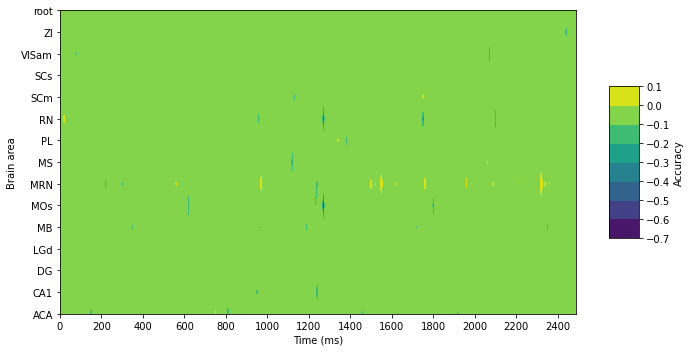

In [16]:
import matplotlib.pyplot as plt

def plot_scores(scores,session,save_fn):
    spikes_per_region, _, n_timebins = prepare_data(session=session)
    regions = spikes_per_region.keys()
    
    fig = plt.figure(figsize=[10,5])
    contour = plt.contourf(scores)
    cb = fig.colorbar(contour, shrink=0.5, aspect=5)
    cb.set_label('Accuracy')
    tick_marks = np.arange(len(regions))
    plt.yticks(tick_marks, regions)
    plt.xticks(np.arange(0,n_timebins,20), np.arange(0,n_timebins*10,200))
    plt.ylabel('Brain area')
    plt.xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()
    fig.savefig(results_folder+save_fn,format='png')
    
def plot_all_sessions():
    n_sessions = 39
    for i in range(n_sessions):
        scores = simple_decoder(session=i)
        plot_scores(scores,i,'scores_s%d.png'%i)
    
if __name__=="__main__":
    scores = simple_decoder_pupil(session=12)
    plot_scores(scores,12,'scores_pupil_s12.png')
    # plot_all_sessions()